## Logging

https://docs.python.org/3/library/logging.html

In [ ]:
from fastapi import FastAPI, HTTPException
from fastapi import File, UploadFile
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from PIL import Image
import uvicorn
import logging


logging.basicConfig(filename="app.log", level=logging.INFO)
logging.info("Starting APP")


app = FastAPI()

try:
    model = load_model('model.h5')
except Exception as e:
    logging.info(f"Error loading model: {e}")
    model = None

@app.get("/health")
async def health_check():
    logging.info("Health check endpoint accessed")
    return {"status": "OK"}


@app.post('/predict')
async def predict(image_file: UploadFile = File(...)):
    if not model:
        raise HTTPException(status_code=500, detail="Model could not be loaded")
    try:
        image = Image.open(image_file.file)
        image = np.expand_dims(image, axis=0)
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Error processing image: {e}")

    try:
        predictions = model.predict(image)
        logging.info(f"Predictions: {predictions}")
    except Exception as e:

        logging.error(f"Error making prediction: {e}")
        raise HTTPException(status_code=500, detail=f"Error making prediction: {e}")

    try:
        predicted_class = np.argmax(predictions[0])
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error interpreting prediction: {e}")

    return {"predicted_class": int(predicted_class)}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=80)

# Data Drift

Se refiere al cambio en las relaciones entre los datos de entrada y salida en el problema subyacente a lo largo del tiempo.

En otros dominios puede llamarse **“covariate shift,” “dataset shift,” or “nonstationarity.”**

In [7]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)

In [3]:
def motion_blur(image, size=5):

    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    output = cv2.filter2D(image, -1, kernel_motion_blur)
    return output

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

170498071/170498071 [==============================] - 6s 0us/step


 ### Agreguemos motion-blur con un grado creciente de severidad

In [5]:
X_test_blur_2 = np.array([motion_blur(x, size=2) for x in X_test])
X_test_blur_5 = np.array([motion_blur(x, size=5) for x in X_test])
X_test_blur_15 = np.array([motion_blur(x, size=15) for x in X_test])

Text(0.5, 1.0, 'Motion Blur (size=15)')

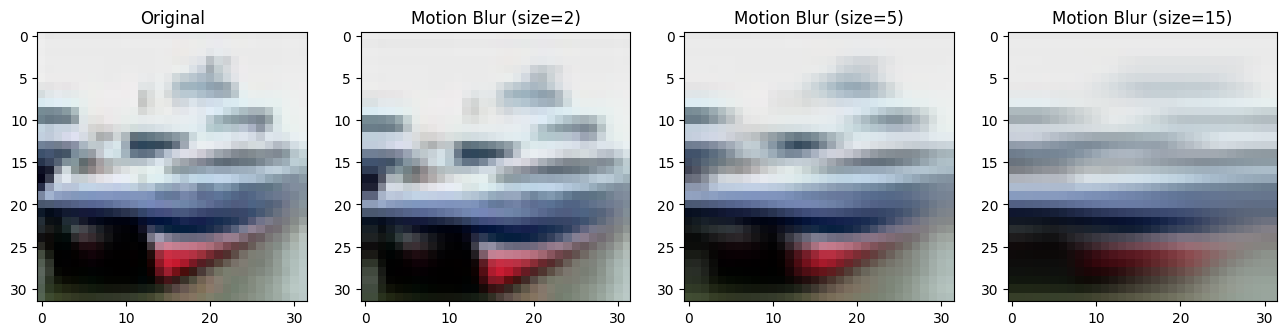

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(X_test[1])
axs[0].set_title('Original')
axs[1].imshow(X_test_blur_2[1])
axs[1].set_title('Motion Blur (size=2)')
axs[2].imshow(X_test_blur_5[1])
axs[2].set_title('Motion Blur (size=5)')
axs[3].imshow(X_test_blur_15[1])
axs[3].set_title('Motion Blur (size=15)')

### Demostrando el Model Drift

Mostraremos el model drift entrenando una Red Neuronal Convolucional muy simple y ejecutando inferencia tanto en el conjunto de pruebas original como en imágenes perturbadas. Si el modelo es susceptible a la deriva de concepto, esperamos que el rendimiento en el conjunto de pruebas disminuya gradualmente.






In [9]:
from tensorflow.keras import datasets, layers, models

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 91s 57ms/step - loss: 1.4957 - accuracy: 0.4570 - val_loss: 1.2280 - val_accuracy: 0.5634
Epoch 2/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.1281 - accuracy: 0.6015 - val_loss: 1.0456 - val_accuracy: 0.6305
Epoch 3/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.9750 - accuracy: 0.6585 - val_loss: 0.9667 - val_accuracy: 0.6560
Epoch 4/10
1563/1563 [==============================] - 82s 52ms/step - loss: 0.8757 - accuracy: 0.6927 - val_loss: 0.9477 - val_accuracy: 0.6700
Epoch 5/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.8012 - accuracy: 0.7194 - val_loss: 0.8782 - val_accuracy: 0.6929
Epoch 6/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.7449 - accuracy: 0.7384 - val_loss: 0.8911 - val_accuracy: 0.6954
Epoch 7/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.6862 - accuracy: 0.7580 - val_loss: 0.9008 -

In [12]:
yh = np.argmax(model.predict(X_test), axis=-1)
yh_blur_2 = np.argmax(model.predict(X_test_blur_2), axis=-1)
yh_blur_5 = np.argmax(model.predict(X_test_blur_5), axis=-1)
yh_blur_15 = np.argmax(model.predict(X_test_blur_15), axis=-1)

313/313 [==============================] - 4s 14ms/step


In [13]:
print('Original Accuracy: ' + str(np.sum(y_test == yh) / len(y_test)))
print('Blur (size=2) Accuracy: ' + str(np.sum(y_test == yh_blur_2) / len(y_test)))
print('Blur (size=5) Accuracy: ' + str(np.sum(y_test == yh_blur_5) / len(y_test)))
print('Blur (size=15) Accuracy: ' + str(np.sum(y_test == yh_blur_15) / len(y_test)))

Original Accuracy: 0.7132
Blur (size=2) Accuracy: 0.6836
Blur (size=5) Accuracy: 0.4866
Blur (size=15) Accuracy: 0.2651


La precisión del modelo está disminuyendo a medida que introducimos más motion-blur